In [1]:
import pandas as pd
import numpy as np
import re
from faker import Faker
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
import requests
from bs4 import BeautifulSoup
import string
import time
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import warnings
warnings.filterwarnings("ignore")

# A2. Crawling and classifying YouTube comments from Greek pages


## I. Language detection

### 1. Build a language detector (Greek/Greeklish/English/Other) using RegExps.

In [2]:
def detect_language(text):
    greek_pattern = re.compile(r'[\u0370-\u03FF\s]+')
    english_pattern = re.compile(r'[a-zA-Z\s]+')
    greeklish_pattern = re.compile(r'[a-zA-Z\u0370-\u03FF\s]+')
    text_without_punctuation = re.sub(r'[.,!]', '', text)
    if greek_pattern.fullmatch(text_without_punctuation):
        return 'el'
    elif english_pattern.fullmatch(text_without_punctuation):
        return 'en'
    elif greeklish_pattern.fullmatch(text_without_punctuation):
        return 'greeklish'
    elif re.search(r'[a-zA-Z]', text_without_punctuation):
        return 'other'  # Check for Latin characters not covered by English
    else:
        return 'other'

### 2. Create a ground truth evaluation dataset and assess your classifier. (Hint: you are free to manually extract data from online sources.) This dataset will be submitted as a CSV named as gold.csv.

In [3]:
'''
We downloaded a language detection dataset from 
https://huggingface.co/datasets/papluca/language-identification/tree/main, renamed all labels to either greek,
english or other. We randomly sampled 3500 from the 'other' label to have a balanced df. 
Finally we copied the greek text and added fake english to create synthetic greeklish text.

df = pd.read_csv("lang_df.csv")
def classify_language(language):
    if language in ['en', 'el']:
        return language
    else:
        return 'other'

# Apply the function to the 'language' column
df['labels'] = df['labels'].apply(classify_language)
english_df = df[df['labels'] == 'en']
greek_df = df[df['labels'] == 'el']
other_df = df[df['labels'] == 'other']
faker = Faker()
greeklish_df = pd.DataFrame(columns=['labels', 'text'])
greeklish_df['text'] = greek_df['text'] + " " + faker.text()
greeklish_df['labels'] = 'greeklish'
random_other_df = other_df.sample(n=3500, random_state=42)
result_df = pd.concat([english_df, greek_df, greeklish_df, random_other_df], ignore_index=True)
result_df.to_csv('gold.csv', index=False)
'''
gold_df = pd.read_csv('gold.csv')
gold_df

,labels,text
0,en,Didnt really seem to work much.
1,en,Highly recommend for those who don't like bein...
2,en,Fascinating premise and characters. The only c...
3,en,"This was perfect for my tree and decor, good p..."
4,en,"This product does help with dry skin. However,..."
...,...,...
13995,other,Chi phí cho mỗi hoạt động bưu điện ( xử lý thư...
13996,other,Pássaro preto sentado numa laje de betão.
13997,other,ホバリングが凄く敏感で安定しています。 風速14メートルくらいでも全然平気でした。 地上から...
13998,other,เงา ของ สัตว์ร้าย ถูกจับ adrin และ เขา กระ...


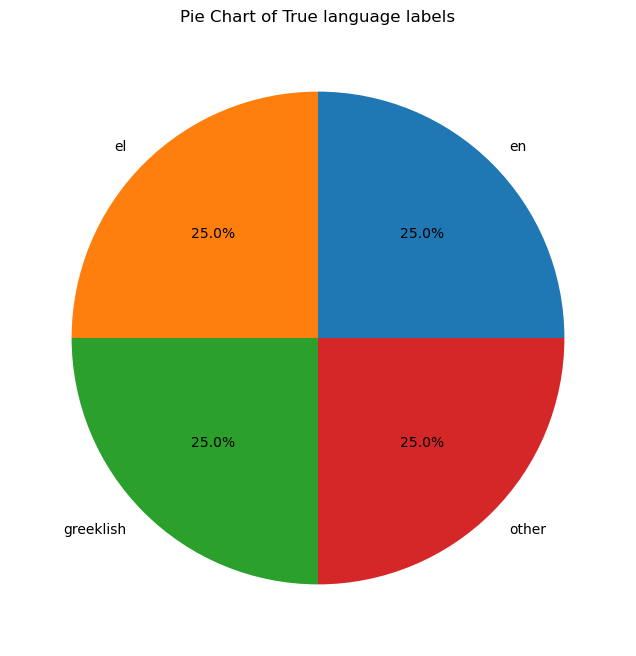

In [4]:
category_counts = gold_df['labels'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
category_counts.plot.pie(autopct='%1.1f%%')
plt.title('Pie Chart of True language labels')
plt.ylabel('')
plt.show()

In [5]:
gold_df['lang_classification'] = gold_df.apply(lambda row: detect_language(row['text']), axis=1)
gold_df

,labels,text,lang_classification
0,en,Didnt really seem to work much.,en
1,en,Highly recommend for those who don't like bein...,other
2,en,Fascinating premise and characters. The only c...,en
3,en,"This was perfect for my tree and decor, good p...",en
4,en,"This product does help with dry skin. However,...",other
...,...,...,...
13995,other,Chi phí cho mỗi hoạt động bưu điện ( xử lý thư...,other
13996,other,Pássaro preto sentado numa laje de betão.,other
13997,other,ホバリングが凄く敏感で安定しています。 風速14メートルくらいでも全然平気でした。 地上から...,other
13998,other,เงา ของ สัตว์ร้าย ถูกจับ adrin และ เขา กระ...,other


In [6]:
gold_df['agreement'] = (gold_df['labels'] == gold_df['lang_classification']).astype(int)

In [7]:
gold_df['agreement'].value_counts()

1    9158
0    4842
Name: agreement, dtype: int64

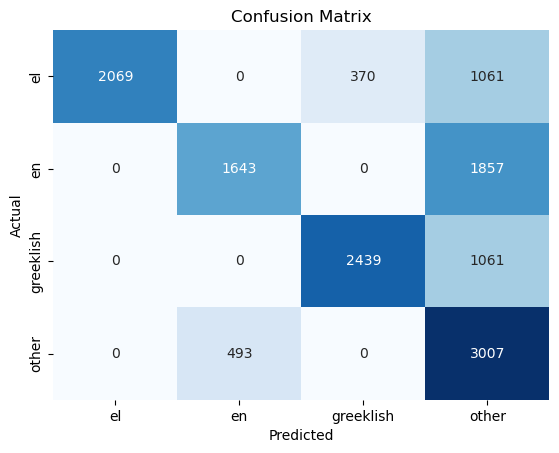

In [8]:
class_names = ['el','en','greeklish','other']

# Assuming your DataFrame is named 'df' and the columns are 'actual_values' and 'predicted_values'

# Create a confusion matrix
conf_matrix = confusion_matrix(gold_df['labels'], gold_df['lang_classification'])

# Create a heatmap for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
classification_report_result = classification_report(gold_df['labels'], gold_df['lang_classification'])
print("Classification Report:")
print(classification_report_result)

Classification Report:
              precision    recall  f1-score   support

          el       1.00      0.59      0.74      3500
          en       0.77      0.47      0.58      3500
   greeklish       0.87      0.70      0.77      3500
       other       0.43      0.86      0.57      3500

    accuracy                           0.65     14000
   macro avg       0.77      0.65      0.67     14000
weighted avg       0.77      0.65      0.67     14000



In [10]:
print(f"Mutual Info Score: {mutual_info_score(gold_df['labels'].values, gold_df['lang_classification'].values)}")
print(f"Normalized Mutual Info Score: {normalized_mutual_info_score(gold_df['labels'].values, gold_df['lang_classification'].values)}")
print(f"Adjusted Mutual Info Score: {adjusted_mutual_info_score(gold_df['labels'].values, gold_df['lang_classification'].values)}")

Mutual Info Score: 0.5832214727321215
Normalized Mutual Info Score: 0.44438119252630975
Adjusted Mutual Info Score: 0.4442450303320342


## II. Crawl YouTube for videos with Greek posts

### 1. Apply your language detector to the page’s title.

In [11]:
def remove_punctuation(input_text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return input_text.translate(translator)

In [12]:
def find_title_lang(soup):
    title_tag = soup.find('title')
    if title_tag:
        return detect_language(remove_punctuation(title_tag.text)) 
    else:
        print("No <title> tag found.")

### 2. Parse all the comments of the page but only if the title is in Greek/Greeklish.

### 3. Use a strategy to jump to other pages that *will likely* have Greek/Greeklish titles.

In [13]:
def parse_comments(video_url,titles):
    comment_list = []
    comment_dates = []
    comments = []
    with Chrome() as driver: # path to geckodriver for older versions 
        try:
            driver.get(video_url)
            wait = WebDriverWait(driver,15)

            # Scroll down to load comments (adjust the number of scrolls as needed)
            for _ in range(5):  # Scroll down 5 times; adjust as needed
                driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
                time.sleep(2)  # Wait for the page to load

            # Find and extract the comments
            page_title = driver.title
            comments = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#comment")))
        except TimeoutException:
            print(f"No comments found for title: {page_title}")
            
        container_class = "your_container_class"
        container_element = driver.find_element(By.CLASS_NAME, "style-scope ytd-watch-next-secondary-results-renderer")  
        links = [a.get_attribute('href') for a in container_element.find_elements(By.TAG_NAME, 'a') if a.get_attribute('href')]
        for comment in comments:
            comment_text = comment.find_element(By.CSS_SELECTOR, "#content-text").text
            comment_date = comment.find_element(By.CSS_SELECTOR, "#header-author > yt-formatted-string > a").text
            comment_list.append(comment_text)
            comment_dates.append(comment_date)
        for link in links:
            response = requests.get(link)
            if response.status_code == 200:
                html_content = response.text
                soup1 = BeautifulSoup(html_content, 'html.parser')
                title_tag = soup1.find('title')
                if title_tag.text in titles:
                    continue
                else:
                    if (find_title_lang(soup1) == "greeklish" or find_title_lang(soup1) == "el"):
                        new_url = link
                        page_title = title_tag.text
                        return (comment_list,comment_dates, new_url,page_title)
                    else:
                        page_title = title_tag.text
                        new_url = link
    driver.quit()
    return (comment_list,comment_dates, new_url,page_title)

In [ ]:
df = pd.DataFrame(columns=["title", "comment","date"])
url = "https://www.youtube.com/watch?v=XqmT7TGsa0o"
titles = []
for i in range(25):
    (comments,dates,url,title) = parse_comments(url,titles)
    print(title)
    titles.append(title)
    for i in range(len(comments)):
        df = df.append({"title": title, "comment": comments[i],"date":dates[i]}, ignore_index=True)
df

In [15]:
df

,title,comment,date
0,ΕΚΑΝΕ ΤΟ ΚΑΛΥΤΕΡΟ NIDALEE GAME! | Dom1nant - Y...,Domizerahansera locoananera,4 months ago
1,Όταν έχεις συμπαίκτη είναι πιο EASY! - YouTube,μλκ τι εκανες εκει με Nida ρε παιχτη ?. Αυτα τ...,6 months ago (edited)
2,Όταν έχεις συμπαίκτη είναι πιο EASY! - YouTube,Ο λιλ ποπ ειναι αυτος ?,6 months ago
3,Adapting στο game = PERMA ΚΑΛΟΣ - YouTube,wlg epilipsy confirmed?,1 year ago
4,Adapting στο game = PERMA ΚΑΛΟΣ - YouTube,RRRRRRRRRRRRRRRRRRRRRR,1 year ago
...,...,...,...
1025,"Δημ. Δαββέτας : Ο Ναπολέων, η ταινία Σκοτ, η ...",Εξαιρετικη,11 hours ago
1026,"Δημ. Δαββέτας : Ο Ναπολέων, η ταινία Σκοτ, η ...","""Δεν υπάρχουν πολλά τέτοια προστατευμενα σημει...",6 hours ago
1027,"Δημ. Δαββέτας : Ο Ναπολέων, η ταινία Σκοτ, η ...",Κύριε Σαχίνη θα ήταν ωραία καλεσμένη στις αντ...,8 hours ago
1028,"Δημ. Δαββέτας : Ο Ναπολέων, η ταινία Σκοτ, η ...","αυτό το ""Δεν επηρεάζει ο Ηλιος το Κλίμα"" εεεεχ...",9 hours ago


### 4. Form a CSV with the crawled information, to be submitted named as crawl.csv.

In [16]:
df.to_csv("crawl.csv",index=False)